In [1]:
import train

number of parameters: 0.000082 M 
step 0: train loss 0.6931, val loss 0.6931
step 10: train loss 0.7025, val loss 0.7059
step 20: train loss 0.6947, val loss 0.6950
step 30: train loss 0.6901, val loss 0.6891
step 40: train loss 0.6666, val loss 0.6698
step 50: train loss 0.5417, val loss 0.5479
step 60: train loss 0.2675, val loss 0.2737
step 70: train loss 0.1375, val loss 0.1429
step 80: train loss 0.0903, val loss 0.1156
step 90: train loss 0.0672, val loss 0.0775
step 100: train loss 0.0620, val loss 0.0950
step 110: train loss 0.0608, val loss 0.0605
step 120: train loss 0.0526, val loss 0.0735
step 130: train loss 0.0399, val loss 0.0742
step 140: train loss 0.0391, val loss 0.0550
step 150: train loss 0.0392, val loss 0.0524
step 160: train loss 0.0355, val loss 0.0464
step 170: train loss 0.0336, val loss 0.0471
step 180: train loss 0.0315, val loss 0.0541
step 190: train loss 0.0378, val loss 0.0570
step 200: train loss 0.0318, val loss 0.0643
step 210: train loss 0.0533, val

In [2]:
if train.is_train_heads:
    model_name = f"heads{train.n_head}_embed{train.n_embd}_no_act"
else:
    model_name = f"linear_hid2_embed{train.n_embd}_tanh"
dataset_name = "classify_xor_data"
is_save = True

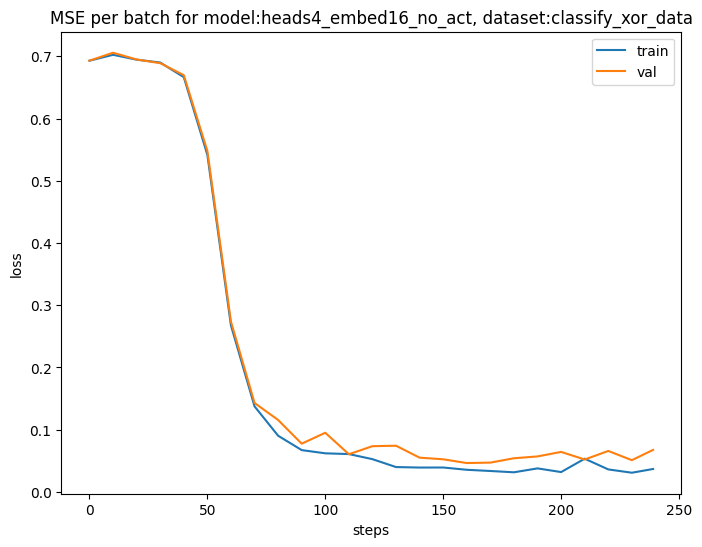

In [3]:
from draw import draw_loss
draw_loss(
    train.iter_list,
    train.train_losses, 
    train.val_losses, 
    f"MSE per batch for model:{model_name}, dataset:{dataset_name}", 
    is_save=is_save
)

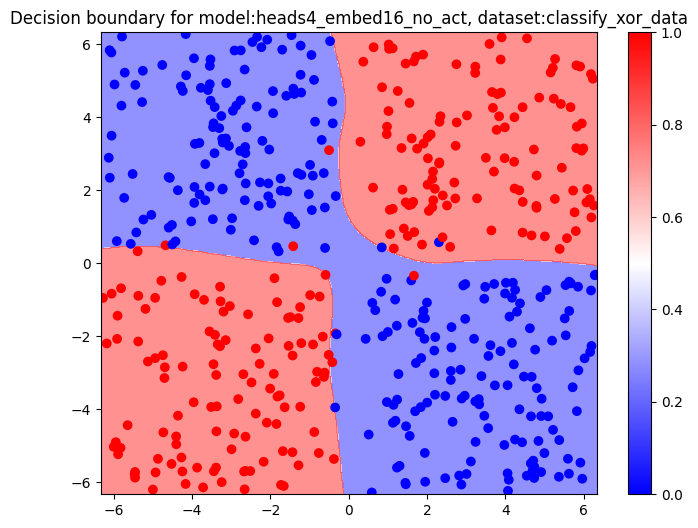

In [4]:
from draw import draw_dataset, draw_decision_boundary
# draw_dataset(train.valset, "Validation set")
draw_decision_boundary(
    train.model, 
    train.valset, 
    f"Decision boundary for model:{model_name}, dataset:{dataset_name}", 
    is_save=is_save,
    task="classification"
)